In [1]:
from pathlib import Path
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import cv2
from einops import rearrange

In [2]:
def get_robust_pca(features: torch.Tensor, m: float = 2, remove_first_component=False):
    # features: (N, C)
    # m: a hyperparam controlling how many std dev outside for outliers
    assert len(features.shape) == 2, "features should be (N, C)"
    reduction_mat = torch.pca_lowrank(features, q=3, niter=20)[2]
    colors = features @ reduction_mat
    if remove_first_component:
        colors_min = colors.min(dim=0).values
        colors_max = colors.max(dim=0).values
        tmp_colors = (colors - colors_min) / (colors_max - colors_min)
        fg_mask = tmp_colors[..., 0] < 0.2
        # cv2.imwrite('fg_mask.png', fg_mask.reshape(32, 32).numpy().astype(np.uint8) * 255)
        # fg_mask2 = tmp_colors[..., 1] < 0.2
        # cv2.imwrite('fg_mask2.png', fg_mask2.reshape(32, 32).numpy().astype(np.uint8) * 255)
        # fg_mask = (fg_mask & fg_mask2)
        reduction_mat = torch.pca_lowrank(features[fg_mask], q=3, niter=20)[2]
        colors = features @ reduction_mat
    else:
        fg_mask = torch.ones_like(colors[:, 0]).bool()
    d = torch.abs(colors[fg_mask] - torch.median(colors[fg_mask], dim=0).values)
    mdev = torch.median(d, dim=0).values
    s = d / mdev
    try:
        rins = colors[fg_mask][s[:, 0] < m, 0]
        gins = colors[fg_mask][s[:, 1] < m, 1]
        bins = colors[fg_mask][s[:, 2] < m, 2]
        rgb_min = torch.tensor([rins.min(), gins.min(), bins.min()])
        rgb_max = torch.tensor([rins.max(), gins.max(), bins.max()])
    except:
        rins = colors
        gins = colors
        bins = colors
        rgb_min = torch.tensor([rins.min(), gins.min(), bins.min()])
        rgb_max = torch.tensor([rins.max(), gins.max(), bins.max()])

    return reduction_mat, rgb_min.to(reduction_mat), rgb_max.to(reduction_mat)


def get_pca_map(
    feature_map: torch.Tensor,
    img_size,
    interpolation="bicubic",
    return_pca_stats=False,
    pca_stats=None,
    remove_first_component=False,
):
    """
    feature_map: (1, h, w, C) is the feature map of a single image.
    """
    # print(feature_map.shape)
    if feature_map.shape[0] != 1:
        # make it (1, h, w, C)
        feature_map = feature_map[None]
    if pca_stats is None:
        reduct_mat, color_min, color_max = get_robust_pca(
            feature_map.reshape(-1, feature_map.shape[-1]),
            remove_first_component=remove_first_component,
        )
    else:
        reduct_mat, color_min, color_max = pca_stats
    pca_color = feature_map @ reduct_mat
    pca_color = (pca_color - color_min) / (color_max - color_min)
    pca_color = pca_color.clamp(0, 1)
    pca_color = F.interpolate(
        pca_color.permute(0, 3, 1, 2),
        size=img_size,
        mode=interpolation,
    ).permute(0, 2, 3, 1)
    pca_color = pca_color.cpu().numpy().squeeze(0)
    if return_pca_stats:
        return pca_color, (reduct_mat, color_min, color_max)
    return pca_color


In [ ]:
from transformers import SegformerModel, SegformerImageProcessor
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

processor = SegformerImageProcessor.from_pretrained('nvidia/segformer-b5-finetuned-ade-640-640')
model = SegformerModel.from_pretrained('nvidia/segformer-b5-finetuned-ade-640-640')

image = cv2.imread('/home/naravich/projects/RADIO/vis_denoise/02005Pre/02005Pre_001.png', cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_size = (640, 640)
image = cv2.resize(image, image_size)
# image = image / 255.0

images = processor(image, return_tensors="pt")
with torch.no_grad():
    output = model(**images)

feat = output.last_hidden_state.cpu().permute(0, 2, 3, 1)
print(feat.shape)
from sklearn.cluster import KMeans
from matplotlib.animation import FuncAnimation

num_rows = num_cols = feat.shape[1]

fig = plt.figure()
axis = plt.axes() 

def animate(frame_number):
    # kmeans = KMeans(n_clusters=frame_number + 1, random_state=0).fit(rearrange(feat, 'b h w c -> (b h w) c', h=num_rows, w=num_cols).numpy())
    kmeans = KMeans(n_clusters=frame_number + 1, random_state=0).fit(feat.reshape(num_cols * num_rows, -1).numpy())

    axis.set_title(f'K: {frame_number}')
    im = axis.imshow(kmeans.labels_.reshape(num_rows, num_cols), interpolation='nearest', cmap='tab20')
    return [im]

anim = FuncAnimation(fig, animate, frames=50, interval=20, blit=True) 
anim.save('kmeans_segformer_b5.mp4', writer='ffmpeg', fps=2)

pca_map = get_pca_map(feat, image_size, interpolation="bilinear")

In [ ]:
pca_map = get_pca_map(feat, image_size, interpolation="bilinear")
pca_map_2 = get_pca_map(feat, image_size, interpolation="bilinear", remove_first_component=True)

sbs = np.concatenate([image / 255, pca_map, pca_map_2], axis=1)
plt.imshow(sbs)
# image.min(), image.max()

In [ ]:
from nnunetv2.run.run_training import get_trainer_from_args

trainer = get_trainer_from_args(dataset_name_or_id="302", configuration="2d", fold=0, trainer_name="nnUNetTrainer", plans_identifier="nnUNetPlans")
trainer.load_checkpoint('/storage_bizon/naravich/nnUNet_Datasets/nnUNet_results/Dataset302_Calcium_OCTv2/nnUNetTrainer__nnUNetPlans__2d/fold_0/checkpoint_best.pth')

In [ ]:
%matplotlib inline
device = torch.device('cuda')
image = cv2.imread('/home/naravich/projects/RADIO/vis_denoise/02005Pre/02005Pre_001.png', cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_size = (512, 512)
image = cv2.resize(image, image_size)
images = image[:, :, 1]
images = images / 255.0
images = images - images.mean()
images /= images.std()
print(images.min(), images.max())
images = images[np.newaxis, ...]
images = torch.tensor(images, device='cpu', dtype=torch.float32)

plt.imshow(images.permute(1, 2, 0).cpu().numpy())
print(images.shape)
with torch.no_grad():
    output = trainer.network.encoder(images.unsqueeze(0).to(device))

In [ ]:
sbs = None
for i in range(len(output)):
    feat = output[i].cpu().permute(0, 2, 3, 1)
    pca_map = get_pca_map(feat, image_size, interpolation="bilinear")
    pca_map_2 = get_pca_map(feat, image_size, interpolation="bilinear", remove_first_component=True)

    sbs_tmp = np.concatenate([image / 255, pca_map, pca_map_2], axis=1)
    sbs = sbs_tmp if sbs is None else np.concatenate([sbs, sbs_tmp], axis=0)
fig, ax = plt.subplots(1, figsize=(20, 50))
ax.imshow(sbs)

In [ ]:
from sklearn.cluster import KMeans
from matplotlib.animation import FuncAnimation

feat = output[4].cpu().permute(0, 2, 3, 1)
num_rows = num_cols = feat.shape[1]

fig = plt.figure()
axis = plt.axes() 

def animate(frame_number):
    # kmeans = KMeans(n_clusters=frame_number + 1, random_state=0).fit(rearrange(feat, 'b h w c -> (b h w) c', h=num_rows, w=num_cols).numpy())
    kmeans = KMeans(n_clusters=frame_number + 1, random_state=0).fit(feat.reshape(num_cols * num_rows, -1).numpy())

    axis.set_title(f'K: {frame_number}')
    im = axis.imshow(kmeans.labels_.reshape(num_rows, num_cols), interpolation='nearest', cmap='tab20')
    return [im]

anim = FuncAnimation(fig, animate, frames=50, interval=20, blit=True) 
anim.save('kmeans_nnunet_calcium.mp4', writer='ffmpeg', fps=2)

# Radio Image

In [6]:
import torch
model_version="radio_v2.1" # for RADIO
#model_version="e-radio_v2" # for E-RADIO
model = torch.hub.load('NVlabs/RADIO', 'radio_model', version=model_version, progress=True, skip_validation=True)
model.cuda().eval()
# x = torch.rand(1, 3, 224, 224, device='cuda')

if "e-radio" in model_version:
    model.model.set_optimal_window_size(x.shape[2:]) #where it expects a tuple of (height, width) of the input image.

preprocessor = model.make_preprocessor_external()

Using cache found in /home/naravich/.cache/torch/hub/NVlabs_RADIO_main
No pretrained configuration specified for vit_huge_patch16_224 model. Using a default. Please add a config to the model pretrained_cfg registry or pass explicitly.


(500, 500, 3)


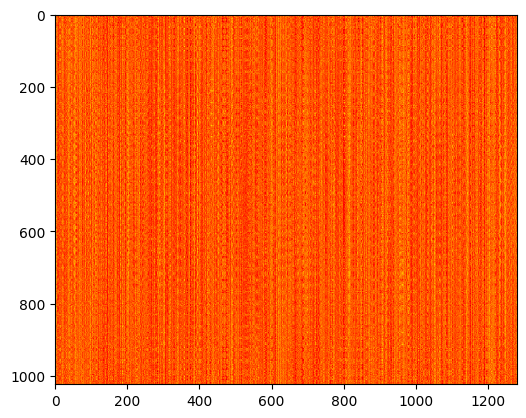

In [39]:
device = torch.device('cuda')
# RADIO expects the input to have values between [0, 1]. It will automatically normalize them to have mean 0 std 1.
# image = cv2.imread('/home/naravich/projects/RADIO/assets/radio.png', cv2.IMREAD_COLOR)
image = cv2.imread('/storage_bizon/naravich/Unlabeled_OCT_by_CADx/CADI/02005Pre/02005Pre_001.png', cv2.IMREAD_COLOR)
# image = image[80:420, 80:420, :]
print(image.shape)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_size = (512, 512)
image = cv2.resize(image, image_size)
image = image / 255.0
# images = processor(image, return_tensors="pt")
image = np.transpose(image, (2, 0, 1))
images = image[np.newaxis, ...]
images = torch.tensor(images, device='cpu', dtype=torch.float32)
# plt.imshow(images[0].permute(1, 2, 0).cpu().numpy())

x = images.to(device)
with torch.autocast(device.type, dtype=torch.bfloat16):
    summary, spatial_features = model(x)
# spatial_features = model(images['pixel_values']).last_hidden_state
# print(spatial_features.shape, len(spatial_features))
plt.imshow(spatial_features.cpu().squeeze(dim=0).detach().numpy(), cmap='hot', interpolation='nearest')
# plt.imshow(spatial_features[0].transpose(1, 2, 0) * 255, cmap='hot', interpolation='nearest')

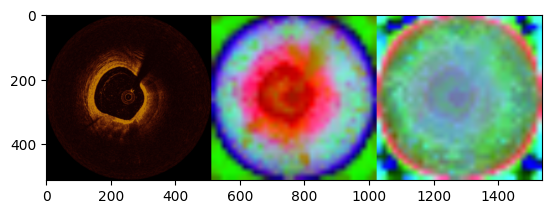

In [40]:
f = spatial_features.cpu().detach()
num_rows = image_size[-2] // 16
num_cols = image_size[-1] // 16
feat = rearrange(f, 'b (h w) c -> b h w c', h=num_rows, w=num_cols).float()

pca_color = get_pca_map(feat, image_size, interpolation="bilinear")
pca_map_2 = get_pca_map(feat, image_size, interpolation="bilinear", remove_first_component=True)
sbs = np.concatenate([images.squeeze(0).permute(1, 2, 0).cpu().numpy(), pca_color, pca_map_2], axis=1)
plt.imshow(sbs)

In [ ]:
from sklearn.cluster import KMeans
from matplotlib.animation import FuncAnimation

fig = plt.figure()
# labeling the x-axis and y-axis 
axis = plt.axes() 

def animate(frame_number):
    # kmeans = KMeans(n_clusters=frame_number + 1, random_state=0).fit(rearrange(feat, 'b h w c -> (b h w) c', h=num_rows, w=num_cols).numpy())
    kmeans = KMeans(n_clusters=frame_number + 1, random_state=0).fit(feat.reshape(num_cols * num_rows, -1).numpy())

    axis.set_title(f'K: {frame_number}')
    im = axis.imshow(kmeans.labels_.reshape(num_rows, num_cols), interpolation='nearest', cmap='tab20')
    return [im]

anim = FuncAnimation(fig, animate, frames=50, interval=20, blit=True) 
anim.save('kmeans_segformer.mp4', writer='ffmpeg', fps=2)

In [43]:
all_feat = [feat]
all_feat = list(zip(*all_feat))
for i, feats in enumerate(all_feat):
    colored = []
    for features in feats:
        # color = get_pca_map(features, images.shape[-2:])
        color = get_pca_map(features, images.shape[-2:], interpolation='bilinear', remove_first_component=True)
        colored.append(color)

    orig = cv2.cvtColor(images[i].permute(1, 2, 0).cpu().numpy(), cv2.COLOR_RGB2BGR)

    # cv2.imwrite(f'{dirs["orig"]}/vis_{ctr}.jpg', orig * 255)
    # cv2.imwrite(f'{dirs["viz"]}/vis_{ctr}.jpg', colored[-1] * 255)

    op = np.concatenate([orig] + colored, axis=1) * 255
    orig = orig * 255
    viz = colored[-1] * 255

    # cv2.imwrite(f'{dirs["sbs"]}/vis_{ctr}.jpg', op)
    sbs = op
    # ctr += 1

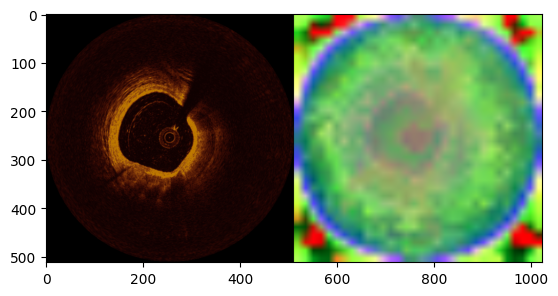

In [44]:
plt.imshow(sbs[:, :, ::-1] / 255)

In [ ]:
viz.min(), viz.max()

In [ ]:
cv2.imwrite('sbs.jpg', sbs)

In [ ]:
viz[:, :, ::-1].shape

In [ ]:
plt.imshow(viz[:, :, ::-1] / 255)